# Trading: Calculate Technical Analysis Indicators with Pandas 🐼

* Link: https://towardsdatascience.com/trading-technical-analysis-with-pandas-43e737a17861

In [24]:
version = '1.0.0'
# if train_build is None -> create today's build
train_start_str = '2018-01-01'
train_end_str = '2019-01-01'
predict_start_str = '2019-10-10'
predict_end_str = '2019-10-17'
validate_start_str = '2019-10-10'
validate_end_str = '2019-10-11'

In [31]:
# set env via .env file
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), verbose=True)

True

In [3]:
import os
import sys
import pathlib 
current_dir = pathlib.Path('.').resolve()
sys.path.append(str(current_dir))
print(f"> current directory:{current_dir}")

> current directory:/mnt/c/notebooks


In [33]:
import numpy as np
import pandas as pd
import importlib
import math
from cachetools import TTLCache
import time
import psutil
import pandas_datareader.data as web
import talib

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [8]:
import shared
import plot

importlib.reload(shared)
importlib.reload(plot)

<module 'plot' from '/mnt/c/notebooks/plot.py'>

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

plot = plot.Notebook()
mpl.rcParams['figure.figsize'] = (16, 9)
mpl.rcParams['axes.grid'] = False
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

In [26]:
cfg = {
    'version': version,
    'build': shared.get_todays_build_version(version)[2],
    'train_start_str': train_start_str,
    'train_start': shared.parse_datetime(train_start_str),
    'train_end_str': train_end_str,
    'train_end': shared.parse_datetime(train_end_str),
    'predict_start_str': predict_start_str,
    'predict_start': shared.parse_datetime(predict_start_str),
    'predict_end_str': predict_end_str,
    'predict_end': shared.parse_datetime(predict_end_str),
    'validate_start_str': validate_start_str,
    'validate_start': shared.parse_datetime(validate_start_str),
    'validate_end_str': validate_end_str,
    'validate_end': shared.parse_datetime(validate_end_str)
}

# print(f'> config: {cfg}')
cfg

{'version': '1.0.0',
 'build': '1.0.0_20191030000000',
 'train_start_str': '2018-01-01',
 'train_start': datetime.datetime(2018, 1, 1, 0, 0),
 'train_end_str': '2019-01-01',
 'train_end': datetime.datetime(2019, 1, 1, 0, 0),
 'predict_start_str': '2019-10-10',
 'predict_start': datetime.datetime(2019, 10, 10, 0, 0),
 'predict_end_str': '2019-10-17',
 'predict_end': datetime.datetime(2019, 10, 17, 0, 0),
 'validate_start_str': '2019-10-10',
 'validate_start': datetime.datetime(2019, 10, 10, 0, 0),
 'validate_end_str': '2019-10-11',
 'validate_end': datetime.datetime(2019, 10, 11, 0, 0)}

In [20]:
symbol = 'AMZN'

In [27]:
df = web.DataReader(name=symbol, data_source='iex', start=cfg['train_start'], end=cfg['train_end'])
df.to_csv("~/{}.csv".format(symbol))
df.head()

,open,high,low,close,volume
date,,,,,
2018-01-02,1172.00,1190.00,1170.51,1189.01,2694494
2018-01-03,1188.30,1205.49,1188.30,1204.20,3108793
2018-01-04,1205.00,1215.87,1204.66,1209.59,3022089
2018-01-05,1217.51,1229.14,1210.00,1229.14,3544743
2018-01-08,1236.00,1253.08,1232.03,1246.87,4279475


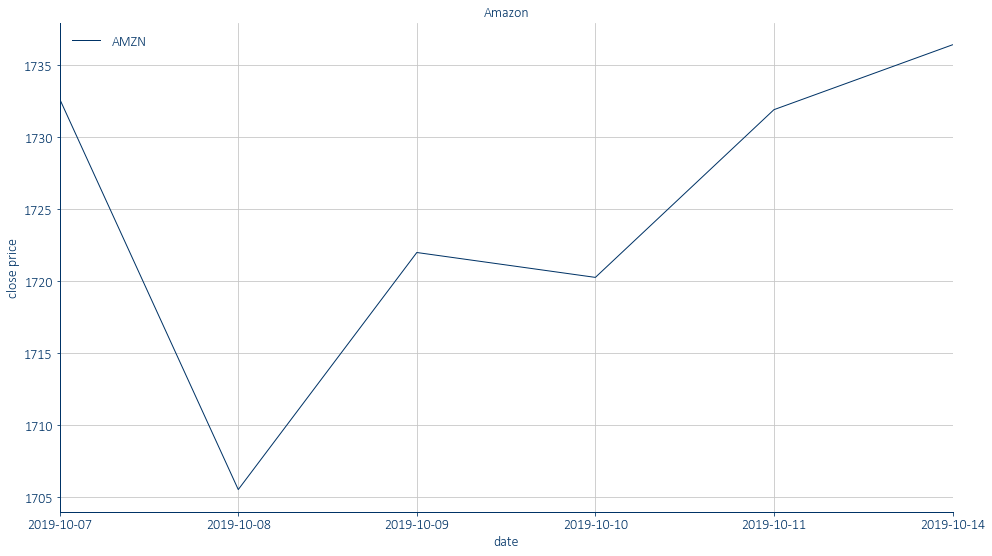

In [23]:
df = pd.read_csv('~/{}.csv'.format(symbol), index_col='date', parse_dates=True, usecols=['date', 'close'], na_values='nan')
# select only close column
close = df[['close']]
# rename the column with symbole name
close = close.rename(columns={'close': symbol})
ax = close.plot(title='Amazon')
ax.set_xlabel('date')
ax.set_ylabel('close price')
ax.grid()
plt.show()

## Bollinger Bands

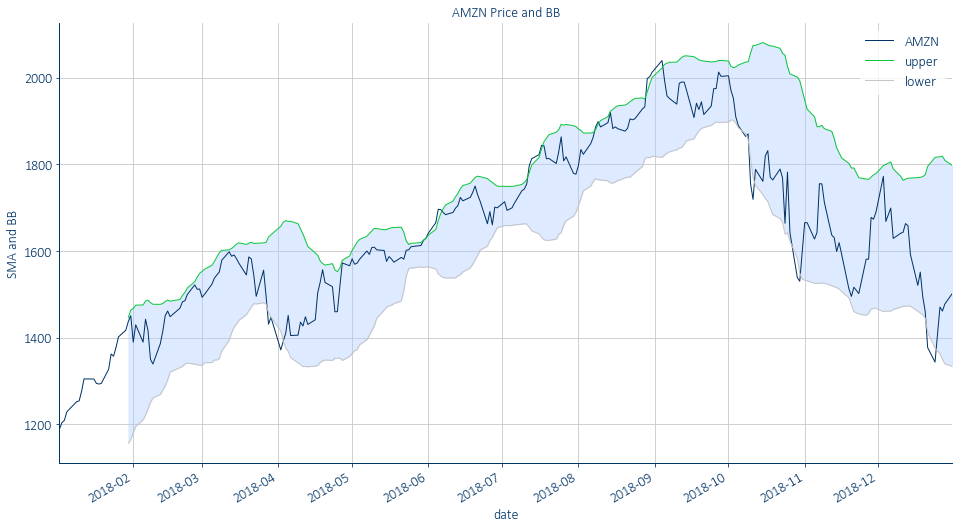

In [28]:
# python version
df = pd.read_csv('~/{}.csv'.format(symbol), index_col='date', parse_dates=True, usecols=['date', 'close'], na_values='nan')
# rename the column header with symbol name
df = df.rename(columns={'close': symbol})
df.dropna(inplace=True)

# MA: calculate Simple Moving Average with 20 days window
sma = df.rolling(window=20).mean()

# volatility: calculate the standard deviation
rstd = df.rolling(window=20).std()

upper_band = sma + 2 * rstd
upper_band = upper_band.rename(columns={symbol: 'upper'})
lower_band = sma - 2 * rstd
lower_band = lower_band.rename(columns={symbol: 'lower'})


df = df.join(upper_band).join(lower_band)
ax = df.plot(title='{} Price and BB'.format(symbol))
ax.fill_between(df.index, lower_band['lower'], upper_band['upper'], color='#ADCCFF', alpha='0.4')
ax.set_xlabel('date')
ax.set_ylabel('SMA and BB')
ax.grid()
plt.show()

In [48]:
# ta-lib version
max_holding = 100
price = web.DataReader(name=symbol, data_source='quandl', start=cfg['train_start'], end=cfg['train_end'])
price = price.iloc[::-1]
price = price.dropna()
close = price['AdjClose'].values
up, mid, low = talib.BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
bbp = (close - low) / (up - low)
rsi = talib.RSI(close, timeperiod=14)
price['RSI'] = talib.RSI(close, timeperiod=14)
price['BBP'] = bbp
price['BB_up'] = up
price['BB_mid'] = mid
price['BB_low'] = low
print("RSI (first 10 elements)\n", rsi[14:24])

RSI (first 10 elements)
 [93.97840742 91.46702894 92.36043761 93.2568968  93.76768196 94.36047879
 94.7310947  72.01234776 76.11490179 67.21725228]


In [49]:
holdings = pd.DataFrame(index=price.index, data={'Holdings': np.array([np.nan] * price.index.shape[0])})
holdings.loc[((price['RSI'] < 30) & (price['BBP'] < 0)), 'Holdings'] = max_holding
holdings.loc[((price['RSI'] > 70) & (price['BBP'] > 1)), 'Holdings'] = 0
holdings.ffill(inplace=True)
holdings.fillna(0, inplace=True)

holdings['Order'] = holdings.diff()
holdings.dropna(inplace=True)

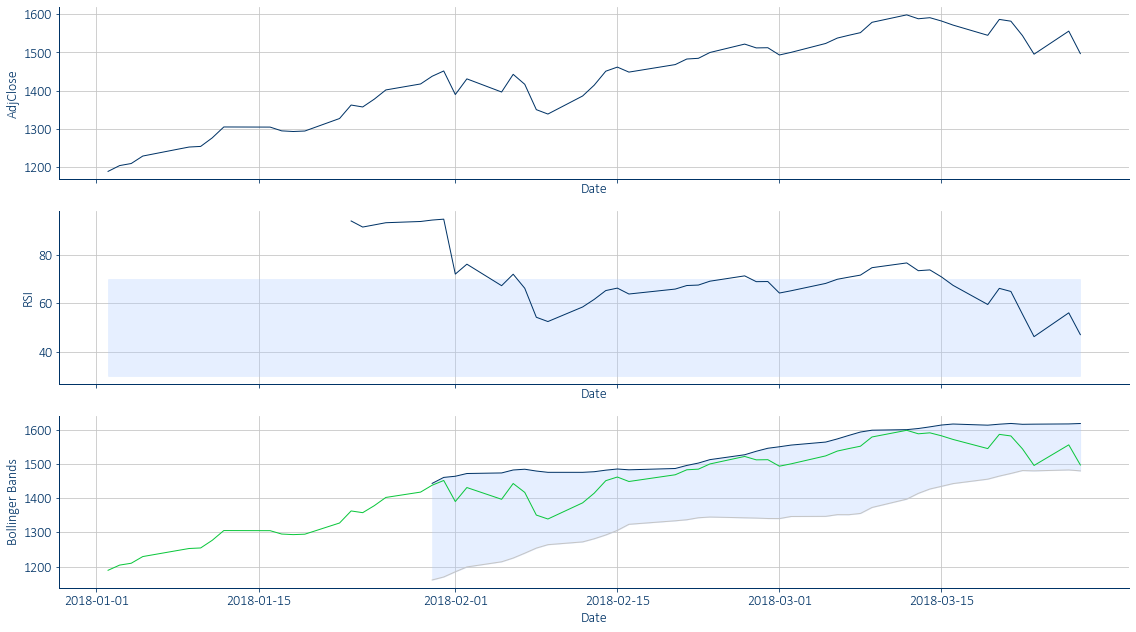

In [50]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True)
ax0.plot(price.index, price['AdjClose'], label='AdjClose')
ax0.set_xlabel('Date')
ax0.set_ylabel('AdjClose')
ax0.grid()
for day, holding in holdings.iterrows():
    order = holding['Order']
    if order > 0:
        ax0.scatter(x=day, y=price.loc[day, 'AdjClose'], color='green')
    elif order < 0:
        ax0.scatter(x=day, y=price.loc[day, 'AdjClose'], color='red')

ax1.plot(price.index, price['RSI'], label='RSI')
ax1.fill_between(price.index, y1=30, y2=70, color='#adccff', alpha='0.3')
ax1.set_xlabel('Date')
ax1.set_ylabel('RSI')
ax1.grid()

ax2.plot(price.index, price['BB_up'], label='BB_up')
ax2.plot(price.index, price['AdjClose'], label='AdjClose')
ax2.plot(price.index, price['BB_low'], label='BB_low')
ax2.fill_between(price.index, y1=price['BB_low'], y2=price['BB_up'], color='#adccff', alpha='0.3')
ax2.set_xlabel('Date')
ax2.set_ylabel('Bollinger Bands')
ax2.grid()

fig.tight_layout()
plt.show()